# EDA 📊 - Exploring the VisualGo Dataset

In [34]:
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import numpy as np

from PIL import Image

import cv2

import os

from skimage.transform import resize
from skimage.draw import polygon2mask, polygon, polygon_perimeter

import torch
import torchvision.transforms as T

import seaborn as sns

from tqdm import tqdm, tqdm_notebook

with open("result.json") as json_file:
    jsonData = json.load(json_file)

1. [Quick introduction 🚀](#Quick-introduction-🚀)
2. [How was this dataset generated?](#How-was-this-dataset-generated?)
3. [A simple parser class with PyTorch dataloader support ⚙️](#A-simple-parser-class-with-PyTorch-dataloader-support-⚙️)
4. [Pixel Heatmap 🗺️](#Pixel-Heatmap-🗺️)

## Quick introduction 🚀

The dataset consists of **over a thousand** of **rendered images** with the size (800 x 800), **polygon masks** defined by four or more coordinates and a **csv files** resembeling the current board states.

The dataset was created with the model architecture I developed in mind, hence the goal is to predict the position of the board and use a perspective warped version of the original image for the state prediction.

## How was this dataset generated?
The VisualGo dataset was created for a project of mine. I recently got into the <a href="https://en.wikipedia.org/wiki/Go_(game)">game of Go</a> after watching the amazing <a href="https://www.alphagomovie.com/">AlphaGo movie</a> and wanted to try to extract the current go state from an image. Since I didn't have the resources neither the time to create a approriate amount of data (creating random board states by hand takes a hell of a time 🙃), I fired up Blender and YouTube to learn how to render photorealistic go boards.

<img src="assets/blenderScript.png">

This left me with these amazing renders, which all use different camera perspectives, lighting and board states. I am actually quite happy with them 😀.

<img src="assets/header1.png">

Rendering these saved me a lot of time and I was hoping that the renders would be close enough to real photos to actual work with them. This is where I realized, that I messed up. How should I predict the board state, without even finding the board itself using image segmentation, hence needing a ground truth mask. This could have been easily done by applying white and black materials to the scene... 

Well, maybe next time.

So I went out to label all thousand images by hand using this amazing opensource tool called <a href="https://labelstud.io/">LabelStudio</a>.

<img src="assets/labelstudio.png">

This left me with the dataset that I used in this project, which we are going to explore in this notebook, to get a better understanding of it.

## A simple parser class with PyTorch dataloader support ⚙️
The following class is a dataloader-compatible parser for the VisualGo Dataset. It loads the images in to memory and creates a ground truth mask with the given polygon coordinates.

The whole dataset is stored in a single json file, which contains the polygon coordinates and the path to the image. 

A single datapoint looks like this:
```json
{'completions': [{'created_at': 1613317720,
   'id': 644001,
   'lead_time': 11.562,
   'result': [{'from_name': 'label',
     'id': 'jMpowm9ISJ',
     'image_rotation': 0,
     'original_height': 800,
     'original_width': 800,
     'to_name': 'image',
     'type': 'polygonlabels',
     'value': {'points': [[68, 14.666666666666666],
       [87.73333333333333, 68.93333333333334],
       [30.133333333333333, 88.13333333333334],
       [13.866666666666667, 31.6]],
      'polygonlabels': ['Board']}}]}],
 'data': {'image': '/data/upload/5020cb-board_643.jpg'},
 'id': 644}
```
Where the ```data``` key gives us the image path and the ```completions``` key the polygon coordinates. Since we are basically performing a two class segmentation (board or no board), we can just ignore the ```polygonlabels``` key.

The mask is created using the ```polygon2mask``` function from ```skimage```. It takes $n$ coordinates and returns a bool-array with the mask:

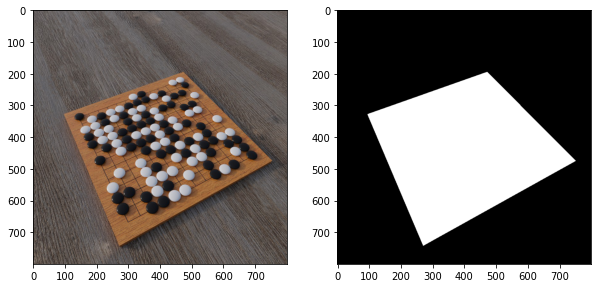

In [16]:
p = jsonData[21]

img = np.array(Image.open("board_masks/upload/" + os.path.basename(p["data"]["image"])))

y = np.array(p["completions"][0]["result"][0]["value"]["points"])
mask = polygon2mask((800,800), y*8).astype(bool).T

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))

ax1.imshow(img)
ax2.imshow(mask, cmap="gray")

In [36]:
# define a dataset class for the Dataloaders
class MaskDataset:
    def __init__(self, baseFile , folder, image_size):
        self.basePath = folder
        self.imageSize = image_size
        
        # load the dataset
        with open(baseFile) as json_file:
            self.jsonData = json.load(json_file)
        
        self.images = []
        
        self.masks = []
        
        # save every image and ground truth mask
        for p in self.jsonData:
            data = p["data"]
            imagePath = data["image"]
        
            self.images.append(np.array(Image.open(self.basePath + os.path.basename(imagePath))))
            
            y = np.array(p["completions"][0]["result"][0]["value"]["points"])
            mask = polygon2mask((800,800), y*8).astype(bool).T
            
            self.masks.append(mask)
    
    def __len__(self):
        return len(self.jsonData)
    
    def __getitem__(self, index):
        
        # a simple image transformer wich resizes the images
        transform = T.Compose([
            T.ToPILImage(),
            T.Resize(self.imageSize),
            T.ToTensor(),
        ])
        
        img = self.images[index]
        X = transform(img)
        
        mask = resize(self.masks[index], (self.imageSize,self.imageSize), order = 0,preserve_range=True)
        
        return X, torch.LongTensor(mask)
    

## Pixel Heatmap 🗺️

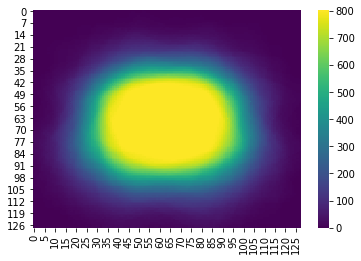

In [37]:
d = MaskDataset("result.json","board_masks/upload/", 128)
hm = d[0][1]
for i in range(1, len(d)):
    hm += d[i][1]
sns.heatmap(hm, cmap="viridis")